In [6]:
# BIBLIOTECAS   
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt

In [7]:
class ExerciseAnalyzer:
    """
    Clase para analizar ejercicios basados en datos de posiciones de landmarks.
    """
    
    # BIBLIOTECAS
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch

    from scipy.signal import savgol_filter, find_peaks
    import matplotlib.pyplot as plt

    def __init__(self, data_path, exercise_key, fps=30, window_length=75, polyorder=5, distance=9, prominence=0.4, distance_thresh=90):
        self.exercise_dict = self._construct_exercise_dict()
        self.data_path = data_path
        self.exercise_key = exercise_key
        self.fps = fps
        self.window_length = window_length
        self.polyorder = polyorder
        self.distance = distance
        self.prominence = prominence
        self.distance_thresh = distance_thresh
        self.df = None
        self.peaks_dict = None
        self.intervals_dict = None
        self.results = None
        self.total_intervals = None
        self.total_peaks = None

    # def run_analysis(self):
        # self.read_data()
        # self.calculate_velocity()
        # self.calculate_smooth_velocity()
        # self.calculate_peaks()
        # self.apply_group_peaks_to_dict()
        # self.create_intervals()
        # self.intervalos_finales()
        # self.picos_finales()
        # self.results = self.contar_picos_y_intervalos_en_tiempo()
        self.read_data()
        self.calculate_velocity()
        self.calculate_smooth_velocity()
        self.calculate_peaks()
        self.apply_group_peaks_to_dict()
        self.create_intervals()
        self.total_intervals = self.final_intervals()
        self.total_peaks = self.final_peaks()

    # DICCIONARIO CON LA RELACION LANDMARK-EJERCICIO
    def _construct_exercise_dict(self):
        exercise_dict = {
        "squat" : {
            "x_axis": [],
            "y_axis": [2, 5, 11, 12],
            "z_axis": [],},
        "lateral_shoulder" : {
            "x_axis": [],
            "y_axis": [15, 16, 17, 18, 19, 20, 21, 22],
            "z_axis": [],},
        }
        return exercise_dict

    # LECTURA DE DATOS
    def read_data(self):
        """
        Lee los datos desde el archivo CSV especificado en data_path.
        """
        self.df = pd.read_csv(self.data_path)
        return self.df

    # CALCULO DE VELOCIDAD
    def calculate_velocity(self):
        """
        Calcula la velocidad en los ejes x, y, z y añade estas velocidades como nuevas columnas en el DataFrame.
        """
        velocity_x = np.zeros(len(self.df))
        velocity_y = np.zeros(len(self.df))
        velocity_z = np.zeros(len(self.df))
        
        for landmark in self.df["landmark"].unique():
            positions_x = self.df.loc[self.df["landmark"] == landmark, "x"].values
            positions_y = self.df.loc[self.df["landmark"] == landmark, "y"].values
            positions_z = self.df.loc[self.df["landmark"] == landmark, "z"].values
            
            dx = np.diff(positions_x)
            dy = np.diff(positions_y)
            dz = np.diff(positions_z)
            
            dt = 1 / self.fps
            
            vx = dx / dt
            vy = dy / dt
            vz = dz / dt
            
            vx = np.insert(vx, 0, 0)
            vy = np.insert(vy, 0, 0)
            vz = np.insert(vz, 0, 0)
            
            velocity_x[self.df["landmark"] == landmark] = vx
            velocity_y[self.df["landmark"] == landmark] = vy
            velocity_z[self.df["landmark"] == landmark] = vz
        
        self.df["vx"] = velocity_x
        self.df["vy"] = velocity_y
        self.df["vz"] = velocity_z
        
        return self.df
    
    # CALCULO DE VELOCIDAD SUAVIZADA
    def calculate_smooth_velocity(self):
        """
        Calcula la velocidad suavizada en los ejes x, y, z y añade estas velocidades suavizadas como nuevas columnas en el DataFrame.
        """
        velocity_x_smooth = np.zeros(len(self.df))
        velocity_y_smooth = np.zeros(len(self.df))
        velocity_z_smooth = np.zeros(len(self.df))
        
        # Iterar sobre cada landmark para aplicar el suavizado
        for landmark in self.df["landmark"].unique():
            # Extraer velocidades para el landmark actual
            vx = self.df.loc[self.df["landmark"] == landmark, "vx"].values
            vy = self.df.loc[self.df["landmark"] == landmark, "vy"].values
            vz = self.df.loc[self.df["landmark"] == landmark, "vz"].values
            
            # Aplicar filtro de suavizado Savitzky-Golay
            vx_smooth = savgol_filter(vx, window_length=self.window_length, polyorder=self.polyorder)
            vy_smooth = savgol_filter(vy, window_length=self.window_length, polyorder=self.polyorder)
            vz_smooth = savgol_filter(vz, window_length=self.window_length, polyorder=self.polyorder)
            
            # Insertar las velocidades suavizadas en las posiciones correspondientes en el array temporal
            velocity_x_smooth[self.df["landmark"] == landmark] = vx_smooth
            velocity_y_smooth[self.df["landmark"] == landmark] = vy_smooth
            velocity_z_smooth[self.df["landmark"] == landmark] = vz_smooth
        
        # Añadir las nuevas columnas suavizadas al DataFrame
        self.df["vx_smooth"] = velocity_x_smooth
        self.df["vy_smooth"] = velocity_y_smooth
        self.df["vz_smooth"] = velocity_z_smooth
        
        return self.df
    
    # CALCULO DE PICOS
    def calculate_peaks(self):
        """
        Calcula los picos en los datos de velocidad suavizada y los almacena en un diccionario.
        """
        # Diccionario para almacenar los picos
        peaks_dict = {}
        
        # Iterar sobre cada landmark único
        for landmark in self.df["landmark"].unique():
            peaks_dict[int(landmark)] = {}
            
            # Iterar sobre cada eje de velocidad
            for axis in ["vx", "vy", "vz"]:
                # Extraer los datos suavizados para el landmark actual y el eje
                data = self.df.query(f"landmark == {landmark}")[f"{axis}_smooth"].tolist()
                
                # Encontrar los picos en los datos suavizados
                peaks, _ = find_peaks(data, distance=self.distance, prominence=self.prominence)
                
                # Almacenar los picos en el diccionario
                peaks_dict[int(landmark)][f"{axis}_sm"] = peaks
        
        self.peaks_dict = peaks_dict
        return self.peaks_dict
    
    # AGRUPAR PICOS
    def _group_peaks(self, peaks, distance_thresh):
        """
        Agrupa los picos que están cerca unos de otros en tramos.
        """
        if len(peaks) == 0:
            return []
        
        peaks = np.sort(peaks)
        peaks = [int(p) for p in peaks]
        
        sections = []
        section_update = [peaks[0]]
        
        for i in range(1, len(peaks)):
            if peaks[i] - peaks[i-1] <= distance_thresh:
                section_update.append(peaks[i])
            else:
                sections.append(section_update)
                section_update = [peaks[i]]
        
        if section_update:
            sections.append(section_update)
        
        return sections

    # APLICAR AGRUPAR PICOS
    def apply_group_peaks_to_dict(self):
        """
        Aplica la función _group_peaks a los picos del diccionario y almacena los resultados en un nuevo diccionario.
        """
        grouped_dict = {}
        
        for key, value in self.peaks_dict.items():
            grouped_dict[key] = {}
            
            for subkey, peaks in value.items():
                if len(peaks) > 0:  # Asegurar que no es un array vacío
                    grouped_dict[key][subkey] = self._group_peaks(peaks, self.distance_thresh)
                else:             
                    grouped_dict[key][subkey] = []
        
        self.peaks_dict = grouped_dict
        return self.peaks_dict

    # CREAR INTERVALOS
    def create_intervals(self):
        """
        Crea intervalos a partir de los picos agrupados y los almacena en un diccionario.
        """
        intervals_dict = {}
        
        for key, axes_dict in self.peaks_dict.items():
            intervals_dict[key] = {}
            
            for axis, lists in axes_dict.items():
                intervals_dict[key][axis] = []
                
                for peak_list in lists:
                    if len(peak_list) == 0:
                        continue
                    elif len(peak_list) == 1:
                        continue
                    else:
                        distances = np.diff(peak_list)
                        avg_distance = int(round(np.mean(distances)))
                        
                        new_start = int(peak_list[0] - 0.5 * avg_distance)
                        new_end = int(peak_list[-1] + 0.5 * avg_distance)
                        intervals_dict[key][axis].append([new_start, new_end])
        
        self.intervals_dict = intervals_dict
        return self.intervals_dict

    ###### INTERVALOS ######
    def _calculate_mean_intervals(self, intervals):
        """
        Calcula la media de los intervalos y redondea al entero más cercano.
        """
        if not intervals:
            return [0, 0]
        
        sum_start = sum(interval[0] for interval in intervals)
        sum_end = sum(interval[1] for interval in intervals)
        n = len(intervals)
        
        media_start = round(sum_start / n)
        media_end = round(sum_end / n)
        
        return [media_start, media_end]
    
    def final_intervals(self):
        """
        Calcula los intervalos finales para el ejercicio dado.
        """
        # Obtener los valores de exercise_dict para la clave dada
        exercise_values = self.exercise_dict[self.exercise_key]

        # Crear una lista para almacenar los intervalos
        final_intervals = []

        for axis, landmarks in exercise_values.items():
            if landmarks:
                grouped_intervals = []
                for landmark in landmarks:
                    if landmark in self.intervals_dict and f'v{axis[0]}_sm' in self.intervals_dict[landmark]:
                        grouped_intervals.append(self.intervals_dict[landmark][f'v{axis[0]}_sm'])
                
                if grouped_intervals:
                    # Agrupar intervalos por su posición (primeros con primeros, segundos con segundos, etc.)
                    overall_intervals = list(zip(*grouped_intervals))
                    for group in overall_intervals:
                        mean_interval = self._calculate_mean_intervals(group)
                        final_intervals.append(mean_interval)
        
        self.total_intervals = final_intervals
        return self.total_intervals
    
    ###### PICOS ######
    def _calculate_mean_peaks(self, peaks_list):
        """
        Calcula la media de los picos y redondea al entero más cercano.
        """
        # Filtrar para quedarse con las listas que tengan el mayor número de elementos
        max_len = max(len(peaks) for peaks in peaks_list)
        filtered_peaks_list = [peaks for peaks in peaks_list if len(peaks) == max_len]

        # Calcular la media de cada conjunto de picos
        transposed_peaks = list(zip(*filtered_peaks_list))
        mean_peaks = [round(np.mean(peak)) for peak in transposed_peaks]
        return mean_peaks

    def final_peaks(self):
        """
        Calcula los picos finales para el ejercicio dado.
        """
        # Obtener los valores de exercise_dict para la clave dada
        exercise_values = self.exercise_dict[self.exercise_key]
        
        # Crear una lista para almacenar los picos medios
        final_mean_peaks = []

        for axis, landmarks in exercise_values.items():
            if landmarks:
                # Crear una lista para almacenar todos los picos de cada eje
                all_peaks = []
                for landmark in landmarks:
                    if landmark in self.peaks_dict and self.peaks_dict[landmark][f'v{axis[0]}_sm']:
                        all_peaks.append(self.peaks_dict[landmark][f'v{axis[0]}_sm'])
                
                # Si hay picos en este eje, calcular la media de cada conjunto de picos
                if all_peaks:
                    num_intervals = len(max(all_peaks, key=len))
                    for i in range(num_intervals):
                        interval_group = [peaks[i] if len(peaks) > i else np.nan for peaks in all_peaks]
                        if all(isinstance(x, list) for x in interval_group):
                            final_mean_peaks.append(self._calculate_mean_peaks(interval_group))
                        else:
                            final_mean_peaks.append(interval_group)
        
        self.total_peaks = final_mean_peaks
        return self.total_peaks
    
    def num_peaks_per_interval(self):
        result = {}
        
        for i, interval in enumerate(self.total_intervals):
            start, end = interval
            counter = sum(1 for peak in self.total_peaks[i] if start <= peak <= end)
            result[i] = {tuple(interval): counter}
        
        return result
    
    def analyze_exercise(self):
        """
        Crea un diccionario que cuenta, para cada intervalo, el número de picos y los convierte a tiempo,
        redondeando al tercer dígito decimal.
        """
        result = {}
        
        for i, (interval, peaks) in enumerate(zip(self.total_intervals, self.total_peaks)):
            start, end = interval
            time_interval = [round(start / self.fps, 3), round(end / self.fps, 3)]
            time_peaks = [round(peak / self.fps, 3) for peak in peaks]
            result[i + 1] = {tuple(time_interval): time_peaks}
        
        return result
    
    def create_graph(self, lndmrk=None):
        # Obtener el landmark por defecto si no se especifica uno
        if lndmrk is None:
            exercise_values = self.exercise_dict[self.exercise_key]
            for axis, landmarks in exercise_values.items():
                if landmarks:
                    lndmrk = landmarks[0]
                    break
        
        if lndmrk is None:
            print("No hay landmarks disponibles para graficar.")
            return
        
        # Crear la figura y el eje
        fig, ax = plt.subplots(figsize=(15, 5))

        # Datos suavizados
        smooth_data = self.df.query(f"landmark == {lndmrk}")['vy_smooth'].reset_index(drop=True)
        
        # Graficar los datos suavizados
        line, = ax.plot(smooth_data, label='Señal suavizada')
        
        # Patch para la leyenda del color verde y rojo
        green_patch = Patch(color='green', alpha=0.3, label='Intervalos')
        red_patch = Patch(color='red', alpha=0.5, label='Picos')
        
        # Colorear los intervalos especificados en verde
        for start, end in self.total_intervals:
            ax.axvspan(start, end, color='green', alpha=0.3)
        
        # Graficar los picos detectados
        flat_peaks = [item for sublist in self.total_peaks for item in sublist]  # Aplanar la lista de listas

        ax.vlines(flat_peaks, ymin=min(smooth_data), ymax=max(smooth_data), color='red', label='Picos', linestyles='dashed')

        # Añadir el número de la repetición sobre cada línea
        for i, peak in enumerate(flat_peaks):
            ax.text(peak, smooth_data[peak], f'{i + 1}', verticalalignment='bottom', horizontalalignment='center')

        # Añadir leyenda y etiqueta
        ax.legend(handles=[line, green_patch, red_patch])

        # Añadir título
        fig.suptitle(f'Visualización de velocidad suavizada con intervalos coloreados y repeticiones detectadas (landmark {lndmrk})')

        # Mostrar la gráfica
        plt.show()

In [8]:
data_path = r"C:\Users\ARMCO\Documents\PROYECTOS\Anaphys\data\data_labeled_15.csv"
ejemplo = ExerciseAnalyzer(data_path, "squat")

In [9]:
ejemplo.analyze_exercise()

{1: {(13.067, 20.7): [14.033, 15.933, 17.9, 19.767]},
 2: {(29.6, 35.6): [30.6, 32.633, 34.6]}}

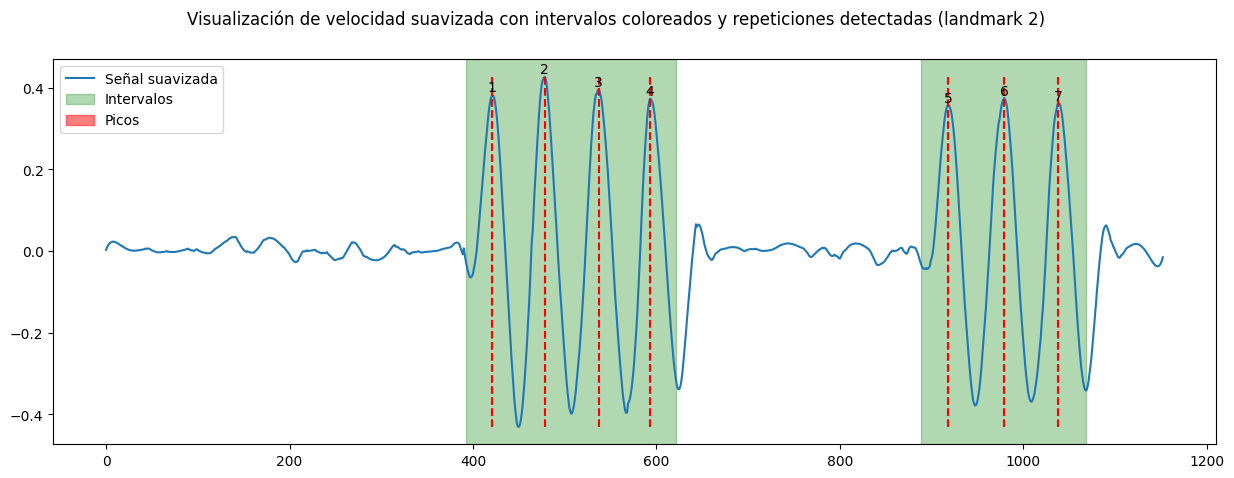

In [10]:
ejemplo.create_graph()